# Data Exploration

In [ ]:
# some basic imports

import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image

In [ ]:
PATH_PREFIX = os.getenv('PATH_PREFIX', "../cil-road-segmentation-2022/")
PATCH_SIZE = 16  # pixels per side of square patches
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

## Load images

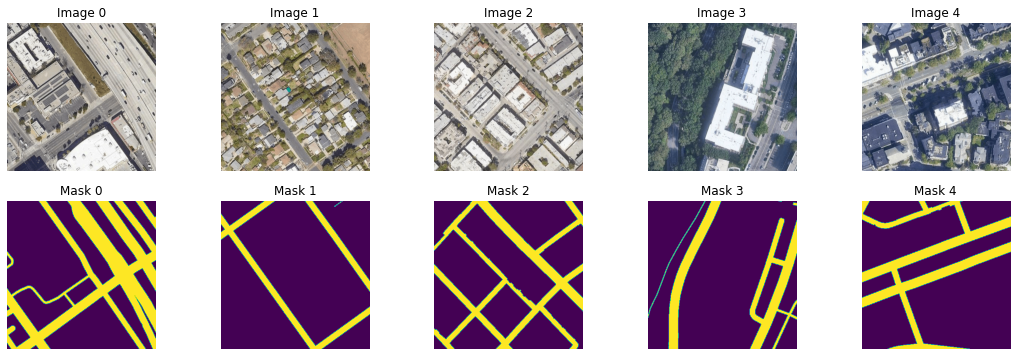

In [ ]:
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    
    file_list = sorted(glob(path + '/*.png'))
    if len(file_list) < 2:
        raise Exception("No list of files found")

    data = np.stack([np.array(Image.open(f)) for f in file_list]).astype(np.float32) / 255.
    return data if len(data.shape) == 3 else np.delete(data, 3, axis=3) # delete the 4th channel (opacity) if present


def show_first_n(imgs, masks, n=5):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(5, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f'Image {i}')
        axs[1, i].set_title(f'Mask {i}')
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()
    

# paths to training and validation datasets
train_path = 'training'
test_path = 'test'

train_images = load_all_from_path(os.path.join(PATH_PREFIX, train_path, 'images'))
train_masks = load_all_from_path(os.path.join(PATH_PREFIX, train_path, 'groundtruth'))

test_images = load_all_from_path(os.path.join(PATH_PREFIX, test_path, 'images'))

# visualize a few images from the training set
show_first_n(train_images, train_masks)


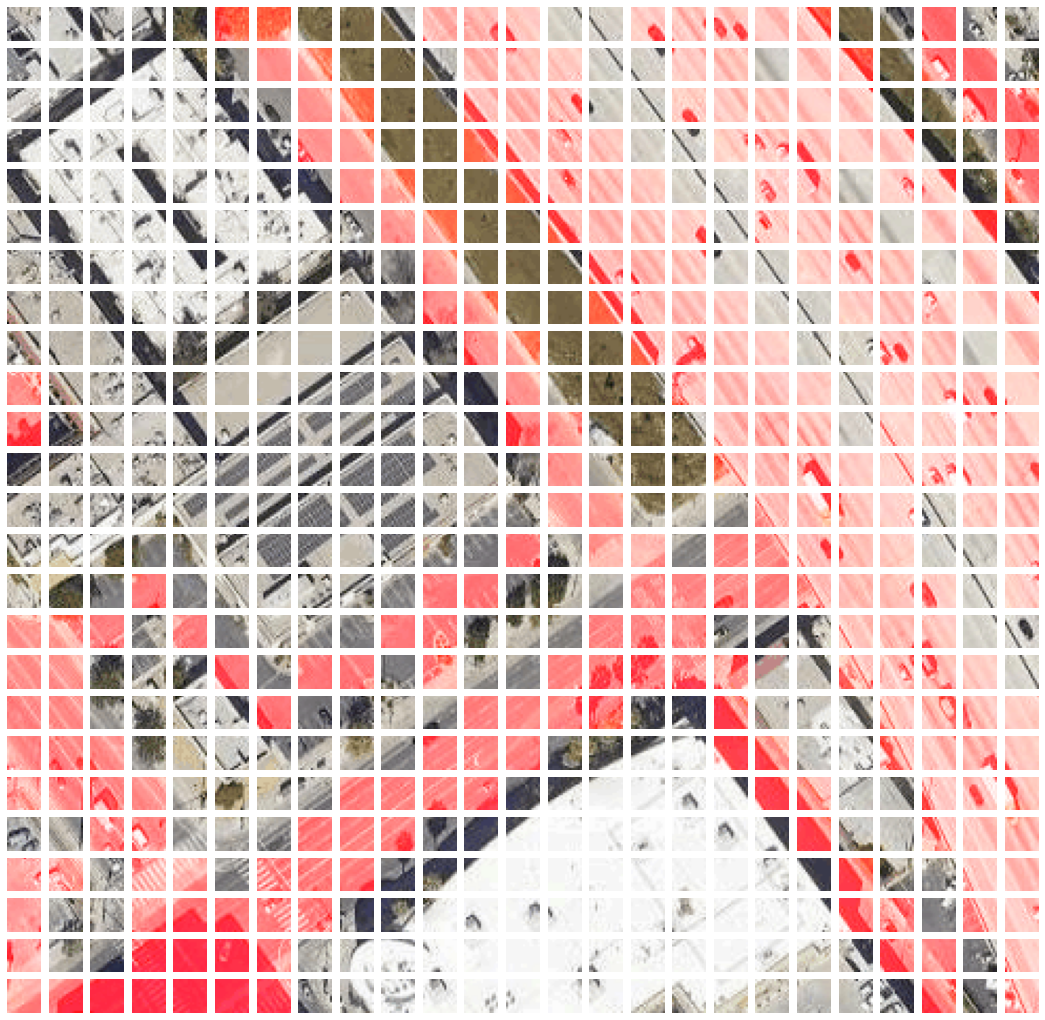

In [ ]:
def image_to_patches(images, masks=None):
    # takes in a 4D np.array containing images and (optionally) a 4D np.array containing the segmentation masks
    # returns a 4D np.array with an ordered sequence of patches extracted from the image and (optionally) a np.array containing labels
    n_images = images.shape[0]  # number of images
    h, w = images.shape[1:3]  # shape of images
    assert (h % PATCH_SIZE) + (w % PATCH_SIZE) == 0  # make sure images can be patched exactly

    h_patches = h // PATCH_SIZE
    w_patches = w // PATCH_SIZE
    patches = images.reshape((n_images, h_patches, PATCH_SIZE, h_patches, PATCH_SIZE, -1))
    patches = np.moveaxis(patches, 2, 3)
    patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    if masks is None:
        return patches

    masks = masks.reshape((n_images, h_patches, PATCH_SIZE, h_patches, PATCH_SIZE, -1))
    masks = np.moveaxis(masks, 2, 3)
    labels = np.mean(masks, (-1, -2, -3)) > CUTOFF  # compute labels
    labels = labels.reshape(-1).astype(np.float32)
    return patches, labels


def show_patched_image(patches, labels, h_patches=25, w_patches=25):
    # reorders a set of patches in their original 2D shape and visualizes them
    fig, axs = plt.subplots(h_patches, w_patches, figsize=(18.5, 18.5))
    for i, (p, l) in enumerate(zip(patches, labels)):
        # the np.maximum operation paints patches labeled as road red
        axs[i // w_patches, i % w_patches].imshow(np.maximum(p, np.array([l.item(), 0., 0.])))
        axs[i // w_patches, i % w_patches].set_axis_off()
    plt.show()


# extract all patches and visualize those from the first image
train_patches, train_labels = image_to_patches(train_images, train_masks)
test_patches = image_to_patches(test_images)

# the first image is broken up in the first 25*25 patches
show_patched_image(train_patches[:25*25], train_labels[:25*25])

## GDS of train and test set

Ground sampling distance (GSD) measures the distance between two pixels. Since the training and test set are of different sizes (400x400 vs 600x600), we want to check if both sets have similar GSD. This would mean that the images are differently sized crops. Alternatively, they could correspond to different zoom levels and thus different GSD.

GSD train: 44.0 cm/px
GSD test: 51.2 cm/px


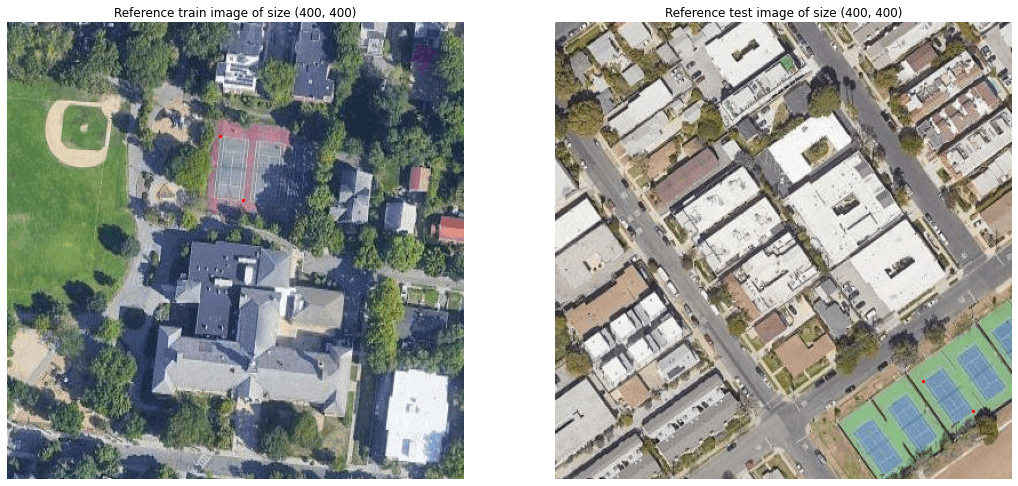

In [ ]:
ref_train = Image.open(os.path.join(PATH_PREFIX, train_path, 'images', 'satimage_127.png'))
ref_test = Image.open(os.path.join(PATH_PREFIX, test_path, 'images', 'satimage_169.png'))


# Tennis court size according to https://en.wikipedia.org/wiki/Tennis_court
court_length_m = 23.77
court_width_m = 10.97 
court_diag_m = np.linalg.norm([court_length_m, court_width_m])

# Tennis court size in train/test images
corner_train_px = np.array([[186,  99], [206, 155]]) # [left_corner, right_corner]
corner_test_px  = np.array([[322, 314], [366, 340]]) # [left_corner, right_corner]
diag_train_px = np.linalg.norm(corner_train_px[0,:] - corner_train_px[1,:])
diag_test_px = np.linalg.norm(corner_test_px[0,:] - corner_test_px[1,:])

# Ground sampling distance train/test set
gsd_train_m = court_diag_m / diag_train_px
gsd_test_m = court_diag_m / diag_test_px
print('GSD train: {:.1f} cm/px'.format(gsd_train_m * 100))
print('GSD test: {:.1f} cm/px'.format(gsd_test_m * 100))


_, ax = plt.subplots(1, 2, figsize=(18, 18))
ax[0].imshow(ref_train)
ax[0].scatter(corner_train_px[:,0], corner_train_px[:,1], c='red', s=5)
ax[0].set_title(f'Reference train image of size {ref_train.size}')
ax[0].set_axis_off()

ax[1].imshow(ref_test)
ax[1].scatter(corner_test_px[:, 0], corner_test_px[:, 1], c='red', s=5)
ax[1].set_title(f'Reference test image of size {ref_test.size}')
ax[1].set_axis_off()
plt.show()

## Color Histogram

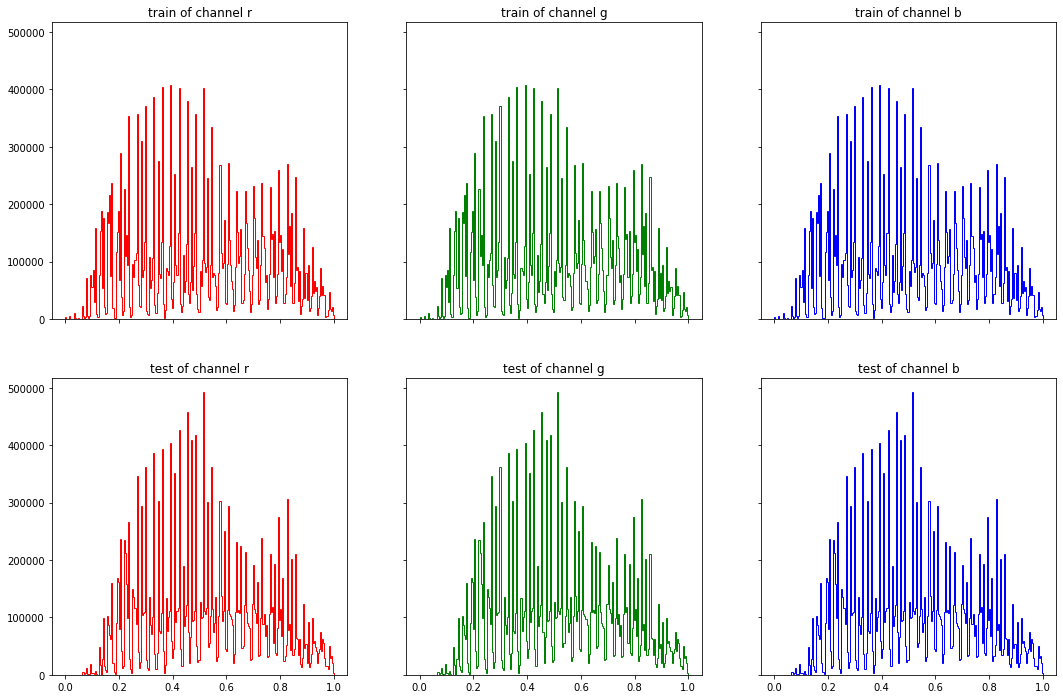

In [ ]:
# Color Channel Histogramms
f, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(18,12<))
for i, ds in enumerate(['train', 'test']):
    for j, c in enumerate(['r', 'g', 'b']):
        ax[i,j].set_title(f'{ds} of channel {c}')
        if ds == 'train':
            ax[i, j].hist(train_images[:,:,:,i].ravel(), bins=256, histtype='step', color=c)
        else:
            ax[i, j].hist(test_images[:,:,:,i].ravel(), bins=256, histtype='step', color=c)
plt.show()

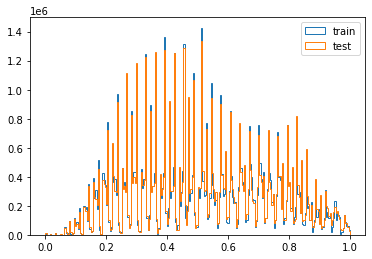

In [ ]:
# Overlaid Class histograms
plt.hist(train_images.ravel(), bins=256, histtype='step', label='train')
plt.hist(test_images.ravel(), bins=256, histtype='step', label='test')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddedec99-c003-49f8-9064-90484ffbe195' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>